* https://docs.quantum.ibm.com/guides/run-jobs-batch
* https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Batch

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, Batch
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


def plot_data(x, y, fig=None, ax=None):
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="tab:orange", s=20)
    ax.scatter(x[blues, 0], x[blues, 1], c="tab:blue", s=20)
    ax.set_xlabel("$x_1$", fontsize=15)
    ax.set_ylabel("$x_2$", fontsize=15)
    ax.set_xticks([-1, 0, 1])
    ax.set_yticks([-1, 0, 1])
    ax.set_aspect("equal")
    for a in ["x", "y"]:
        plt.tick_params(axis=a, labelsize=15)


def two_spirals(_n_points, noise=0.8):
    """
    Returns the two spirals dataset.
    """
    n_points = _n_points // 2
    n = np.sqrt(np.random.rand(n_points, 1)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(n_points, 1) * noise
    d1y = np.sin(n) * n + np.random.rand(n_points, 1) * noise
    x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 10.0
    y = np.hstack((np.zeros(n_points), np.ones(n_points)))
    return x, y

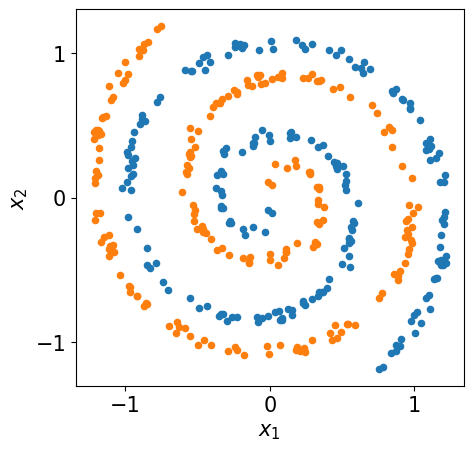

In [2]:
np.random.seed(42)

X, y = two_spirals(400)
plot_data(X, y)

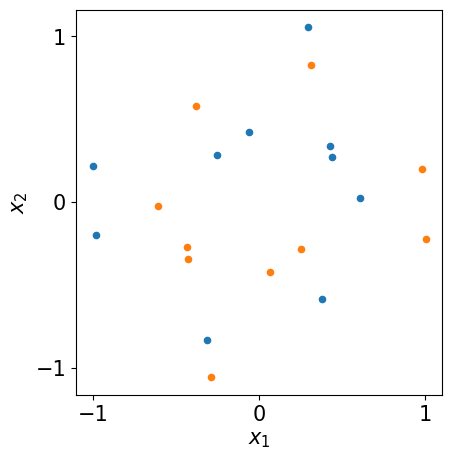

In [3]:
# 20 points we would like to test on IBM quantum
X, y = two_spirals(20)
plot_data(X, y)

In [4]:
n_layers = 15

param = """
1.873457,-1.271325,1.574982,0.581540,3.125468;-1.740409,0.464150,-0.787948,-0.407372,2.233190;2.337631,-1.089066,-1.437560,0.668919,-0.025033;0.720979,-1.240496,1.026050,-0.771492,0.580650;1.675318,-1.306447,-0.511799,-0.985686,0.892292;2.227948,-2.079982,0.098623,-0.080788,-0.001149;1.946551,-2.667200,0.109069,0.489111,-0.406843;1.075479,-2.032830,0.239851,-1.051282,0.508573;0.480355,-1.058879,1.691445,1.994997,0.672091;-2.296355,-0.572643,0.015525,0.088538,1.678404;0.423832,0.562777,0.344113,-0.514148,0.085048;-0.226999,-0.372636,0.220690,-0.287838,0.556229;1.199385,-1.548740,0.489988,-0.345803,1.511788;-1.711430,0.500284,1.993603,-0.283929,1.016596;1.928735,-0.470987,0.900611,0.374044,-0.207826
"""

param = np.array([[float(p) for p in pp.split(",")] for pp in param.split(";")])

Here is fidelity of measuring |1> with the model given by those parameters: 

![Fidelity |1>](./figures/spirals-fidelity-U3-1.png)

In [5]:
# API token from https://quantum.ibm.com/ (requires registration)
TOKEN = "..."

service = QiskitRuntimeService(channel="ibm_quantum",
                               token=TOKEN,
                               )
# Run on the least-busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)
backend.name

'ibm_brisbane'

In [6]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuits = []
for i in range(len(X)):
    x = X[i]
    
    # Quantum circuit with one quantum and one classical bits
    qc = QuantumCircuit(1, 1)
    
    for p in param:
        qc.u(p[0] * x[0], p[1] * x[1], 0, qubit=0)
        qc.u(p[2], p[3], p[4], qubit=0)
    
    circuits.append(qc)

for circuit in circuits:
    circuit.measure_all()
    
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuits = pm.run(circuits)

/Users/bp/Env/qiskit/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/bp/Env/qiskit/lib/python3.12/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


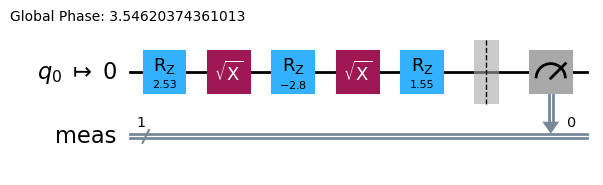

In [7]:
# A circuit producing "0"
isa_circuits[0].draw(output="mpl", idle_wires=False, style="iqp")

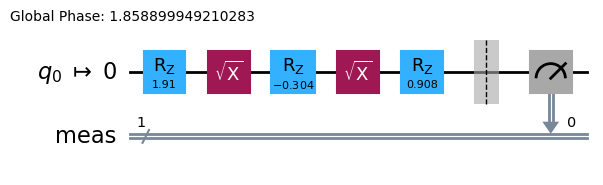

In [8]:
# A circuit producing "1"
isa_circuits[10].draw(output="mpl", idle_wires=False, style="iqp")

In [9]:
max_circuits = 10
all_partitioned_circuits = []
for i in range(0, len(isa_circuits), max_circuits):
    all_partitioned_circuits.append(isa_circuits[i : i + max_circuits])
jobs = []
start_idx = 0
 
with Batch(backend=backend) as batch:
    sampler = Sampler()
    for partitioned_circuits in all_partitioned_circuits:
        job = sampler.run(partitioned_circuits, shots=1024)
        jobs.append(job)

In [10]:
# Collect results from all jobs
results = [job.result() for job in jobs]

In [22]:
# Tabulate
print("#", "Prob0", "Prob1", "TrueLabel")

for j in range(len(results)):
    for i, result in enumerate(results[j]):
        c = result.data.meas.get_counts()
        shots = c["0"] + c["1"]
        n = max_circuits * j + i
        print(n, round(c["0"] / shots, 2), round(c["1"] / shots, 2), y[n])

# Prob0 Prob1 TrueLabel
0 0.91 0.09 0.0
1 0.93 0.07 0.0
2 0.83 0.17 0.0
3 0.84 0.16 0.0
4 0.86 0.14 0.0
5 0.83 0.17 0.0
6 0.92 0.08 0.0
7 0.74 0.26 0.0
8 0.88 0.12 0.0
9 0.91 0.09 0.0
10 0.03 0.97 1.0
11 0.06 0.94 1.0
12 0.03 0.97 1.0
13 0.04 0.96 1.0
14 0.02 0.98 1.0
15 0.09 0.91 1.0
16 0.02 0.98 1.0
17 0.07 0.93 1.0
18 0.04 0.96 1.0
19 0.02 0.98 1.0
